In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from msresist.clustering import DDMC
from msresist.pre_processing import preprocessing
import pandas as pd
import numpy as np

matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

### 1. Do good AXL substrates preferentially show up in one of the clusters?

In [2]:
axl = preprocessing(AXLm_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
d = axl.select_dtypes(include=['float64']).T
i = axl.select_dtypes(include=['object'])

# Fit DDMC
ddmc_axl = DDMC(i, n_components=5, SeqWeight=2, distance_method="PAM250", random_state=5).fit(d)
axl.insert(0, "Cluster", ddmc_axl.labels())

X = pd.read_csv("/home/marcc/AXLomics/msresist/data/Validations/BacterialDisplay/AXL_ms_data.csv")[["Protein", "Sequence", "Position", "Gene", "enrich_net", "enrich_net_btn"]]
X.insert(6, "Net Enrichment Score", X[["enrich_net", "enrich_net_btn"]].mean(axis=1))
assert np.all(X["Protein"].values == axl["Protein"].values)
X.insert(0, "Cluster", ddmc_axl.labels())
X = X.sort_values(by="Net Enrichment Score", ascending=False).dropna()

<AxesSubplot: xlabel='Net Enrichment Score', ylabel='Count'>

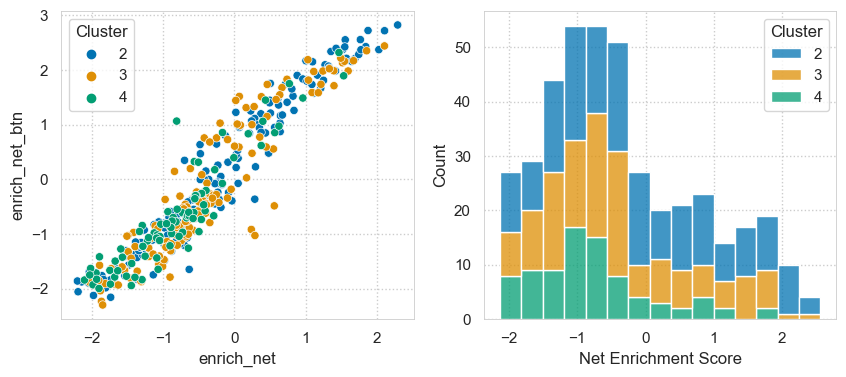

In [3]:
_, ax = plt.subplots(1, 2, figsize=(10, 4))
X["Cluster"] = X["Cluster"].astype(str)
X = X.sort_values(by="Cluster")
sns.scatterplot(data=X, x="enrich_net", y="enrich_net_btn", hue="Cluster", ax=ax[0])
sns.histplot(X, x="Net Enrichment Score", hue="Cluster", multiple="stack", ax=ax[1], bins=15)

### Hypergeometric Test

Hypergeometric test using the top 25% of enriched substrates. Test parameters:
- Number of successes "k": Number of cluster memberships among top 25% = [0, 60, 34, 10, 0]
- Sample size "s": Number of peptides among the the top 25% = 104
- Number of sucesses in the population "M": Cluster sizes = [19, 184, 157, 83, 48]
- Population size: Mass spec data set size = 491

p-values:
- Cluster 1: Underenriched 0.01
- Cluster 2: Overenriched 1.89e-6
- Cluster 3: Not significant 0.47
- Cluster 4: Underenriched 0.01
- Cluster 5: Underenriched 5.60e-6

In [4]:
Xenr = X[X["Net Enrichment Score"] >= np.percentile(X["Net Enrichment Score"].dropna().values, 75)]
[list(Xenr["Cluster"]).count(str(ii+1)) for ii in range(5)]

[0, 60, 34, 10, 0]

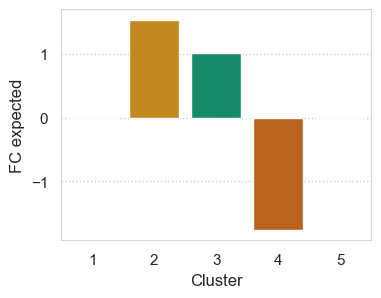

In [5]:
_, ax = plt.subplots(1, 1, figsize=(4, 3))

hg = pd.DataFrame()
hg["Cluster"] = [1, 2, 3, 4, 5]
hg["-log10(p-value)"] = -np.log10([0.01, 1.89e-6, 0.47, 0.01, 5.60e-6])
hg["FC expected"] = [0, 1.54, 1.02, -1.76, 0]
sns.barplot(data=hg, x="Cluster", y="FC expected", ax=ax);

### 2. Within clusters, is there an obvious trend in which phosphosites are higher-scoring (e.g. adapters score higher)?

In [6]:
import gseapy as gp

2023-04-15 18:52:30,861 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-04-15 18:52:30,864 [WARNING] Duplicated values found in preranked stats: 1.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-04-15 18:52:30,865 [INFO] Parsing data files for GSEA.............................
2023-04-15 18:52:30,865 [INFO] Enrichr library gene sets already downloaded in: /home/marcc/.cache/gseapy, use local file
2023-04-15 18:52:30,874 [INFO] 0328 gene_sets have been filtered out when max_size=1000 and min_size=1
2023-04-15 18:52:30,874 [INFO] 0183 gene_sets used for further statistical testing.....
2023-04-15 18:52:30,875 [INFO] Start to run GSEA...Might take a while..................
2023-04-15 18:52:31,038 [INFO] Congratulations. GSEApy runs successfully................



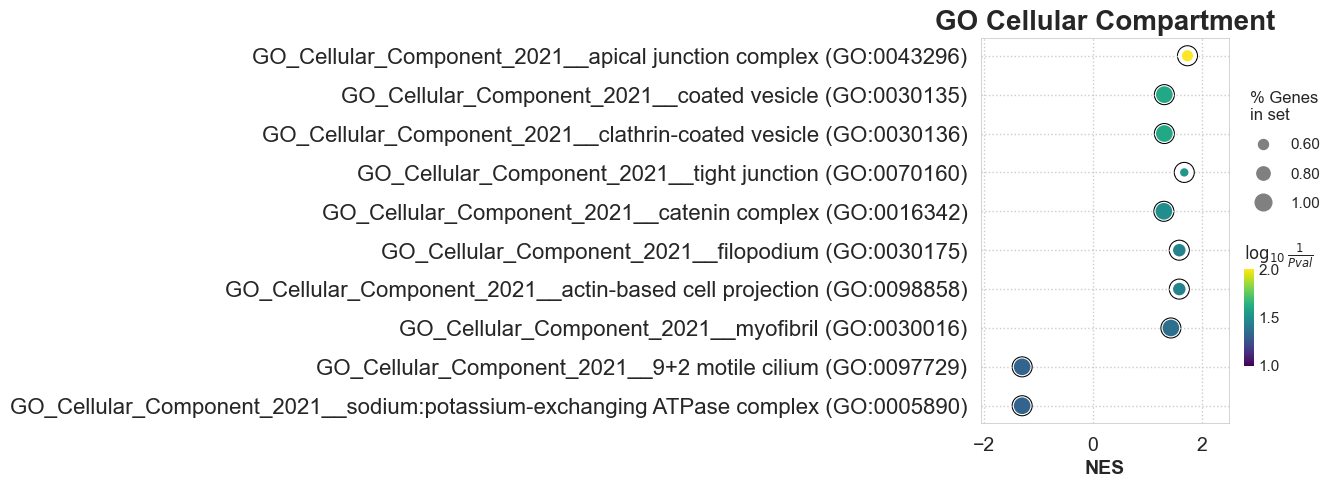

In [17]:
rnk = X.sort_values(by="Net Enrichment Score", ascending=True).dropna().set_index("Gene")[["Net Enrichment Score"]]
pre_res = gp.prerank(rnk=rnk,
                     gene_sets=['GO_Cellular_Component_2021'],
                     threads=4,
                     min_size=1,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

ax = gp.dotplot(pre_res.res2d,
             column="NOM p-val",
             title='GO Cellular Compartment',
             cmap=plt.cm.viridis,
             size=2,
             figsize=(4, 5), 
             cutoff=0.25,
             show_ring=True)

2023-04-15 18:52:54,197 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-04-15 18:52:54,202 [WARNING] Duplicated values found in preranked stats: 1.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-04-15 18:52:54,202 [INFO] Parsing data files for GSEA.............................
2023-04-15 18:52:54,203 [INFO] Enrichr library gene sets already downloaded in: /home/marcc/.cache/gseapy, use local file
2023-04-15 18:52:54,262 [INFO] 3836 gene_sets have been filtered out when max_size=1000 and min_size=1
2023-04-15 18:52:54,263 [INFO] 2200 gene_sets used for further statistical testing.....
2023-04-15 18:52:54,263 [INFO] Start to run GSEA...Might take a while..................
2023-04-15 18:52:55,701 [INFO] Congratulations. GSEApy runs successfully................



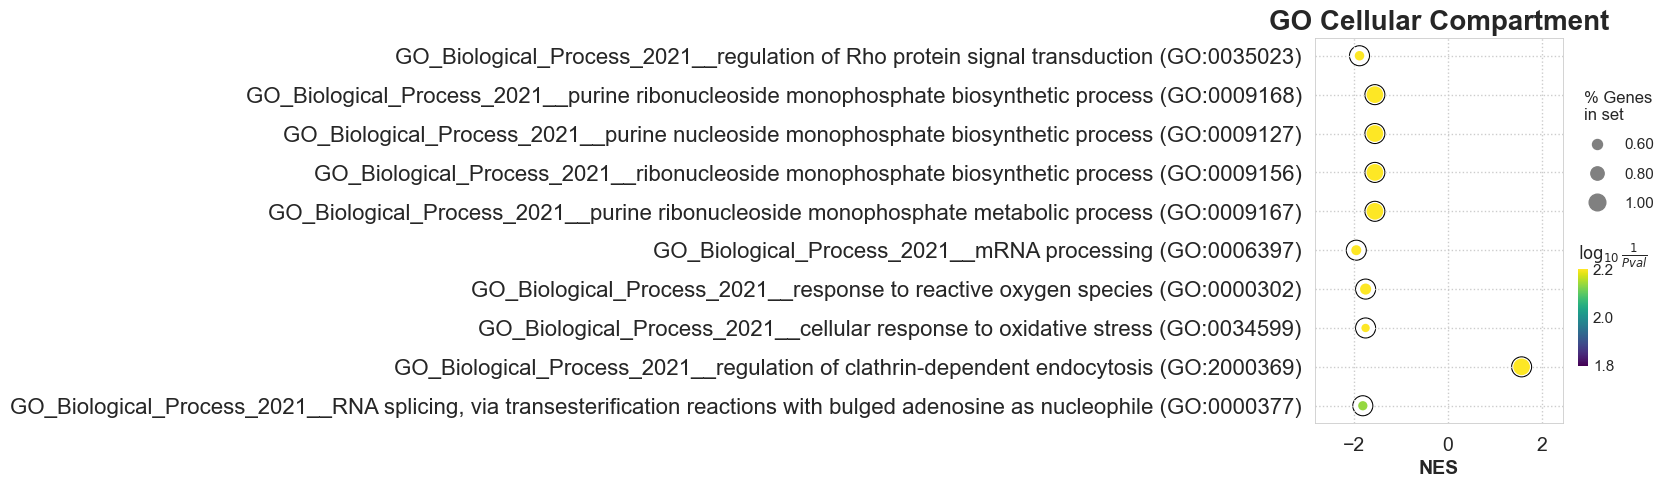

In [18]:
rnk = X.sort_values(by="Net Enrichment Score", ascending=True).dropna().set_index("Gene")[["Net Enrichment Score"]]
pre_res = gp.prerank(rnk=rnk,
                     gene_sets=['GO_Biological_Process_2021'],
                     threads=4,
                     min_size=1,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

ax = gp.dotplot(pre_res.res2d,
             column="NOM p-val",
             title='GO Cellular Compartment',
             cmap=plt.cm.viridis,
             size=2,
             figsize=(4, 5), 
             cutoff=0.25,
             show_ring=True)

2023-04-15 18:53:40,229 [WARNING] Input gene rankings contains duplicated IDs, Only use the duplicated ID with highest value!
2023-04-15 18:53:40,234 [WARNING] Duplicated values found in preranked stats: 1.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2023-04-15 18:53:40,235 [INFO] Parsing data files for GSEA.............................
2023-04-15 18:53:40,236 [INFO] Enrichr library gene sets already downloaded in: /home/marcc/.cache/gseapy, use local file
2023-04-15 18:53:40,254 [INFO] 0952 gene_sets have been filtered out when max_size=1000 and min_size=1
2023-04-15 18:53:40,254 [INFO] 0322 gene_sets used for further statistical testing.....
2023-04-15 18:53:40,255 [INFO] Start to run GSEA...Might take a while..................
2023-04-15 18:53:40,555 [INFO] Congratulations. GSEApy runs successfully................



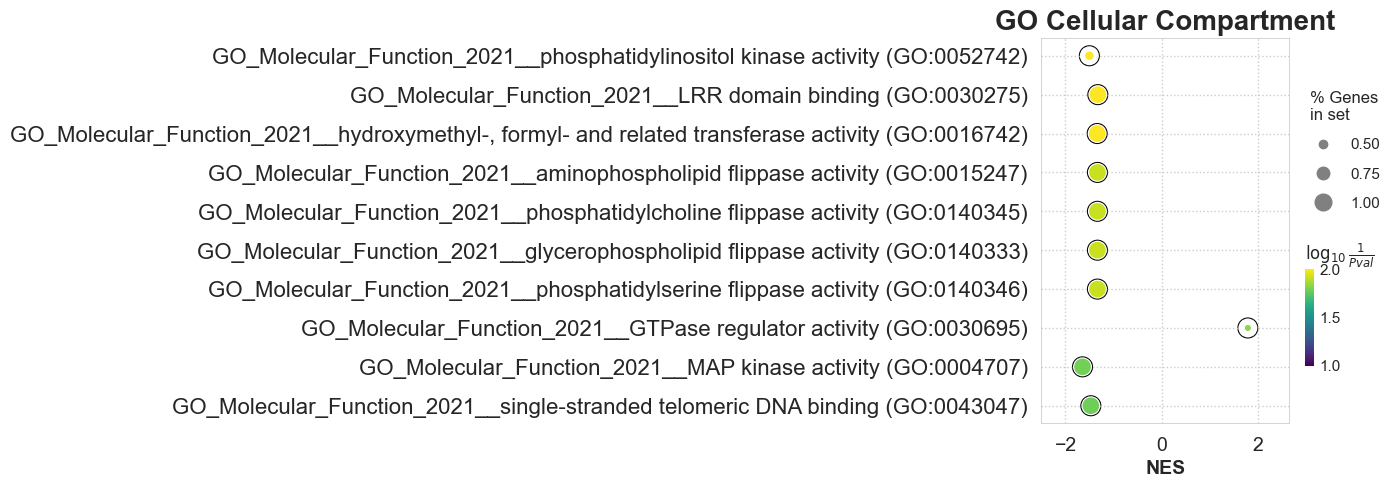

In [19]:
rnk = X.sort_values(by="Net Enrichment Score", ascending=True).dropna().set_index("Gene")[["Net Enrichment Score"]]
pre_res = gp.prerank(rnk=rnk,
                     gene_sets=['GO_Molecular_Function_2021'],
                     threads=4,
                     min_size=1,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

ax = gp.dotplot(pre_res.res2d,
             column="NOM p-val",
             title='GO Cellular Compartment',
             cmap=plt.cm.viridis,
             size=2,
             figsize=(4, 5), 
             cutoff=0.25,
             show_ring=True)

In [8]:
display(X[X["Cluster"] == "2"].sort_values(by="Net Enrichment Score", ascending=False).head(20))
X[X["Cluster"] == "3"].sort_values(by="Net Enrichment Score", ascending=False).head(20)

,Cluster,Protein,Sequence,Position,Gene,enrich_net,enrich_net_btn,Net Enrichment Score
374,2,Rho GTPase-activating protein 42,GKEPIyTLPAI,Y376-p,ARHGAP42,2.296239,2.822681,2.559460
441,2,Tight junction protein ZO-2,KHPDIyAVPIK,Y1118-p,TJP2,2.111754,2.717606,2.414680
151,2,Enhancer of filamentation 1,PRDTIyQVPPS,Y106-p,NEDD9,1.879243,2.721041,2.300142
89,2,Catenin delta-1,PSDQYyWAPLA,Y335-p,CTNND1,2.031710,2.371147,2.201429
189,2,G-protein coupled receptor family C group 5 me...,PSEGAyDIILP,Y387-p,GPRC5C,1.771611,2.554583,2.163097
357,2,Ras and Rab interactor 1,AQDPLyDVPNA,Y36-p,RIN1,1.846876,2.426089,2.136483
285,2,Neural Wiskott-Aldrich syndrome protein,TSKVIyDFIEK,Y256-p,WASL,1.779529,2.369161,2.074345
152,2,Enhancer of filamentation 1,PTKGVyAIPPS,Y223-p,NEDD9,1.558592,2.551583,2.055087
144,2,Enhancer of filamentation 1,GHGYVyEYPSR,Y166-p,NEDD9,1.748832,2.283507,2.016169
156,2,Enhancer of filamentation 1,YQKDVyDIPPS,Y177-p,NEDD9,1.552290,2.421643,1.986966


,Cluster,Protein,Sequence,Position,Gene,enrich_net,enrich_net_btn,Net Enrichment Score
32,3,Activated CDC42 kinase 1,VSSTHyYLLPE,Y859-p,TNK2,2.110623,2.439428,2.275026
93,3,Catenin delta-1,VPSDQyYWAPL,Y334-p,CTNND1,1.859411,2.351290,2.105350
470,3,Tyrosine-protein kinase receptor UFO,ENSEIyDYLRQ,Y759-p,AXL,1.675255,2.169228,1.922241
370,3,Rho GTPase-activating protein 27,PPEPVyANIER,Y228-p,ARHGAP27,1.496332,2.215808,1.856070
484,3,Uridine 5'-monophosphate synthase,LSSPIyIDLRG,Y37-p,UMPS,1.547998,2.158396,1.853197
450,3,Twinfilin-1,TADFLyEEVHP,Y309-p,TWF1,1.520437,2.131334,1.825886
4,3,40S ribosomal protein S10,NRIAIyELLFK,Y12-p,RPS10,1.599589,1.981065,1.790327
235,3,Intersectin-2,EPEALyAAVNK,Y968-p,ITSN2,1.397617,1.984935,1.691276
302,3,"Phosphatidylinositol 3,4,5-trisphosphate 5-pho...",FNNPAyYVLEG,Y986-p,INPPL1,1.335379,2.022120,1.678749
347,3,Pyridoxal-dependent decarboxylase domain-conta...,STEPIyVYKAQ,Y677-p,PDXDC1,1.245725,1.980156,1.612940


In [26]:
abl_sfk = X.set_index("Gene").loc[["ABL1", "SRC", "LCK", "YES1", "FRK", "LYN", "PTK2"]]

,Cluster,Protein,Sequence,Position,enrich_net,enrich_net_btn,Net Enrichment Score
Gene,,,,,,,
ABL1,2,Tyrosine-protein kinase ABL1,SDGKLyVSSES,Y185-p,-0.451241,-0.248728,-0.349984
SRC,2,Proto-oncogene tyrosine-protein kinase Src,STEPQyQPGEN,Y530-p,-0.967805,-0.813645,-0.890725
LCK,2,Tyrosine-protein kinase Lck,IEDNEyTAREG,Y394-p,-0.594437,-0.375928,-0.485182
LCK,2,Tyrosine-protein kinase Lck,DNGGFyISPRI,Y192-p,0.241286,1.066580,0.653933
YES1,2,Tyrosine-protein kinase Yes,LDNGGyYITTR,Y222-p,-0.231219,-0.052172,-0.141695
YES1,2,Tyrosine-protein kinase Yes,SPAIKyRPENT,Y16-p,-2.041613,-1.692217,-1.866915
YES1,2,Tyrosine-protein kinase Yes,PEAALyGRFTI,Y446-p,0.210772,0.841326,0.526049
YES1,3,Tyrosine-protein kinase Yes,TTKGAySLSIR,Y194-p,-1.009869,-1.593153,-1.301511
YES1,4,Tyrosine-protein kinase Yes,DNGGYyITTRA,Y223-p,-0.277051,0.174498,-0.051276


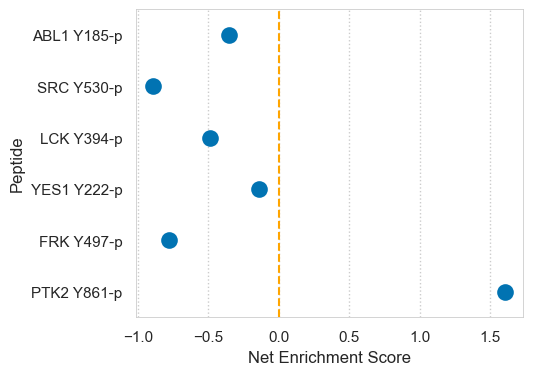

In [43]:
abl_sfk = X.set_index(["Gene", "Position"]).loc[
    [("ABL1", "Y185-p"), 
     ("SRC", "Y530-p"), 
     ("LCK", "Y394-p"),
     ("YES1", "Y222-p"),
     ("FRK", "Y497-p"),
     ("PTK2", "Y861-p")]].reset_index()

abl_sfk.insert(1, "Peptide", [g + " " + p for g, p in zip(list(abl_sfk["Gene"]), list(abl_sfk["Position"]))])

_, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.stripplot(data=abl_sfk, x="Net Enrichment Score", y="Peptide", size=12, ax=ax)
ax.axvline(x=0, color="orange", linestyle="--") 

/home/marcc/AXLomics/.venv/lib/python3.11/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


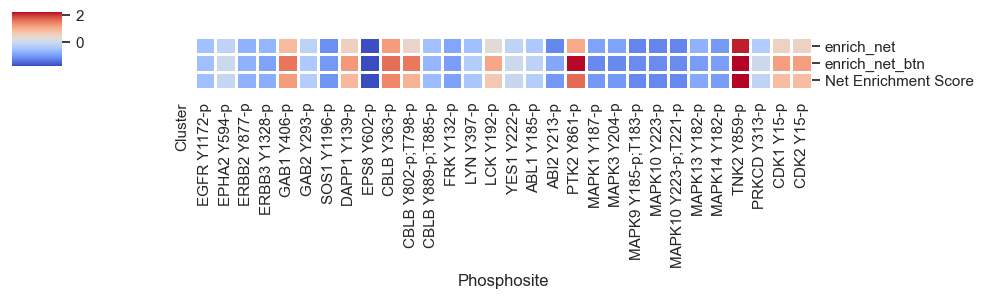

In [51]:
kin = [
    "EGFR Y1172-p",
    "EPHA2 Y594-p",
    "ERBB2 Y877-p",
    "ERBB3 Y1328-p",
    "GAB1 Y406-p",
    "GAB2 Y293-p",
    "SOS1 Y1196-p",
    "DAPP1 Y139-p",
    "EPS8 Y602-p",
    "CBLB Y363-p",
    "CBLB Y802-p;T798-p",
    "CBLB Y889-p;T885-p",
    "FRK Y132-p",
    "LYN Y397-p",
    "LCK Y192-p",
    "YES1 Y222-p",
    "ABL1 Y185-p",
    "ABI2 Y213-p",
    "PTK2 Y861-p",
    "MAPK1 Y187-p",
    "MAPK3 Y204-p",
    "MAPK9 Y185-p;T183-p",
    "MAPK10 Y223-p",
    "MAPK10 Y223-p;T221-p",
    "MAPK13 Y182-p",
    "MAPK14 Y182-p",
    "TNK2 Y859-p",
    "PRKCD Y313-p",
    "CDK1 Y15-p",
    "CDK2 Y15-p",
    ]

# X.insert(0, "Phosphosite", [g + " " + p for g, p in zip(list(X["Gene"]), list(X["Position"]))])
s_ea = X.set_index("Phosphosite").loc[kin][["Cluster", "enrich_net", "enrich_net_btn", "Net Enrichment Score"]]
clusters = s_ea.pop("Cluster")
lut = dict(zip(clusters.unique(), ["darkgreen", "violet", "black", "yellow"]))
row_colors = clusters.map(lut)
sns.clustermap(data=s_ea.T, cmap="coolwarm", row_cluster=False, col_cluster=False, row_colors=row_colors, linewidth=1, linecolor='w', square=True, robust=True, figsize=(10, 3))